# The Truth Particles Collection

The Truth particle collections. This is a little tricky because what is available in an event depends on the sliming algorithms that are applied to the data. The code to access the data is always the same - but the fact that the data is there or not will depend on the file's processing history.

In [1]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21
import matplotlib.pyplot as plt
from config import rucio_zee_r21_mc, xAODLocalTyped, local_xaod_path
import awkward as ak

In [2]:
#ds = SXDSAtlasxAODR21(rucio_zee_r21_mc, backend='dev_xaod')
ds = xAODLocalTyped(local_xaod_path)

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


Most derivations and the AOD's contain a connected combination of particles and vertices. We'll start with particles.

In [9]:
all_particles = (ds
                 .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
                 .Where(lambda tp: (tp.pt() / 1000) > 1)
                 .Select(lambda tp: {
                         'pt': tp.pt() / 1000.0,
                         'pdgId': tp.pdgId(),
                 })
                 .AsAwkwardArray()
                 .value())

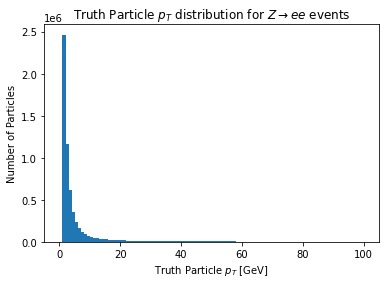

In [10]:
plt.hist(all_particles.pt, bins=100, range=(0, 100))
plt.xlabel('Truth Particle $p_T$ [GeV]')
plt.ylabel('Number of Particles')
_ = plt.title('Truth Particle $p_T$ distribution for $Z\\rightarrow ee$ events')

In [35]:
import numpy as np
import pandas as pd
unique, counts = np.unique(all_particles.pdgId, return_counts=True)
pd.options.display.max_rows = None
df = pd.DataFrame({'PDGId' : unique, 'Count': counts})
df[df.Count>100].sort_values('PDGId', ascending=False)

,PDGId,Count
275,1000020040,175
262,100443,159
256,20443,143
255,20433,226
253,20413,170
250,20313,352
248,20213,1907
243,10441,175
240,10423,153
238,10413,171


In [ ]:
all_particles = (ds
                 .SelectMany(lambda e: e.TruthParticles("TruthParticles"))
                 .Where(lambda tp: (tp.pt() / 1000) > 1)
                 .Select(lambda tp: tp.pt() / 1000.0)
                 .AsAwkwardArray('pt')
                 .value())

## Jet Constituents

Jets are composed of `TopoClusters` in ATLAS, and the AntiKt algorithm normally clusters them into a jet. In R21 files, the `TopoClusters` are easily accessible.

In [ ]:
from servicex import ignore_cache
with ignore_cache():
    topo_clusters = (ds
                     .SelectMany(lambda e: e.Jets("AntiKt4EMTopoJets"))
                     .SelectMany(lambda j: j.getConstituents())
                     .Select(lambda tc: tc.pt())
                     .AsAwkwardArray('JetClusterPt')
                     .value()
                    )

In [ ]:
plt.hist(topo_clusters.JetClusterPt/1000.0, bins=100, range=(0, 20))
plt.xlabel('Jet Cluster $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet Cluster $p_T$ distribution for jets in $Z\\rightarrow ee$ events')

## The Datamodel

The data model when this documentation was last built was:

In [ ]:
from func_adl_servicex_xaodr21.xAOD.truthevent_v1 import TruthEvent_v1
help(TruthEvent_v1)

In [ ]:
from func_adl_servicex_xaodr21.xAOD.truthparticle_v1 import TruthParticle_v1
help(TruthParticle_v1)

## Further Information

* The [`xAOD::TruthEvent_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthEvent_v1.h) with all the inline documentation.
* The [`xAOD::TruthParticle_v1` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthParticle_v1.h) with all the inline documentation.
* The [`xAOD::TruthVertex_v1` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthVertex_v1.h) with all the inline documentation.
* The [`xAOD::TruthPileupEvent_v1` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODTruth/xAODTruth/versions/TruthPileupEvent_v1.h) with all the inline documentation.